In [50]:
from floater import generators as gen 
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import xarray as xr
import pandas as pd

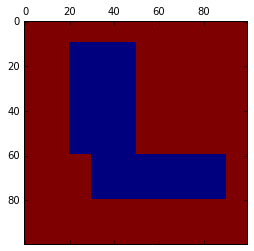

In [68]:
#construct an arbitrary mask
lon = np.arange(0,10,.1)
lat = np.arange(0,10,.1)
land_mask = np.ones((len(lat), len(lon)), dtype='f4')
land_mask[10:60, 20:50] = 0
land_mask[60:80, 30:90] = 0
plt.matshow(land_mask) #an arbitrary mask

In [54]:
model_grid = {'lon': lon, 'lat': lat, 'land_mask': land_mask}
fs = gen.FloatSet((0,10), (0,10), dx=.1, dy=.1,model_grid=model_grid)

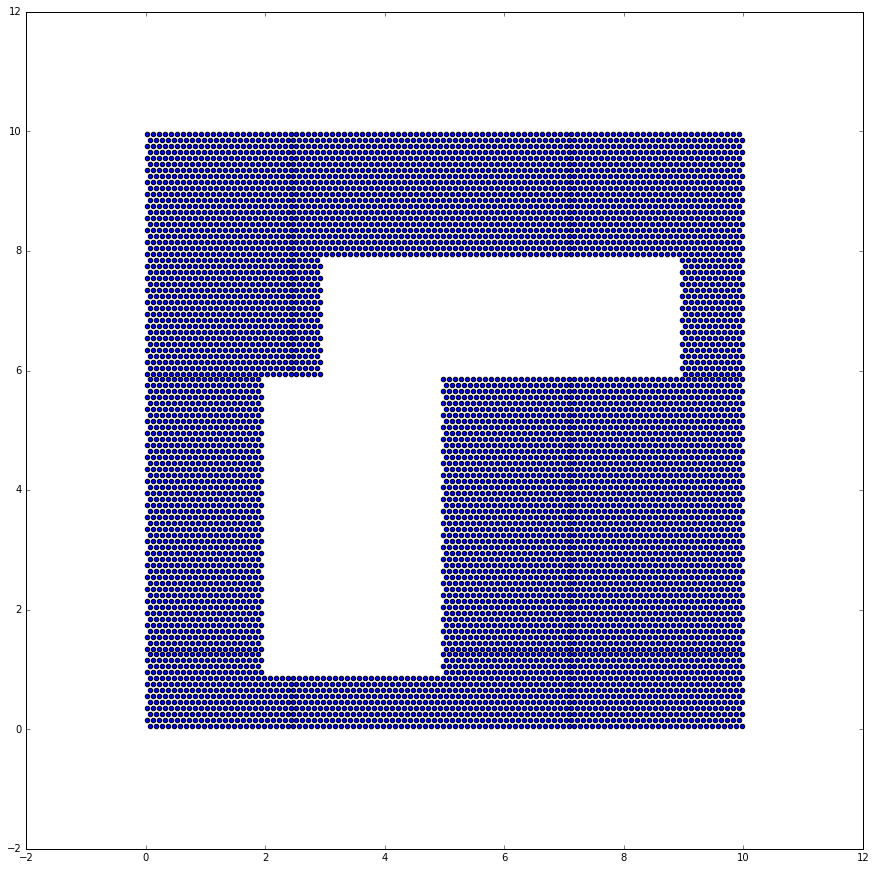

In [70]:
xx,yy = fs.get_hexmesh()
fig, axe = plt.subplots(figsize=(15,15))
plt.scatter(xx.flatten(), yy.flatten()) #plot particle set

In [71]:
#output float file
fs.to_mitgcm_format(mesh=hex,filename='test_floats.bin',read_binary_prec=32)
fs.to_pickle(filename='test_floatset.pkl') #archive FloatSet

In [73]:
#construct fake lAVD field that would be calculated by MITgcm  
flt_matrix = np.fromfile('test_floats.bin', dtype='>f4').reshape(-1,9)
partial_N = int(flt_matrix[0,0]) #the total number of unmasked particles
partial_lavd = pd.DataFrame({'npart':range(1,partial_N+1), 'lavd':np.ones(int(partial_N))})
partial_lavd.head() #is missing the masked particles 

,lavd,npart
0,1.0,1
1,1.0,2
2,1.0,3
3,1.0,4
4,1.0,5


In [76]:
#load in the original Floatset
fs_archived = gen.FloatSet(load_path='test_floatset.pkl')
ocean_bools = fs_archived.ocean_bools 
#ocean_bools[npart] = True, if particle at npart is unmasked
full_N = fs_archived.Nx*fs_archived.Ny

In [77]:
#construct the full lavd series
full_lavd = pd.DataFrame({'npart':range(1,full_N+1), 'lavd':np.zeros(int(full_N))})
#set the unmasked lavd values to the corresponding value in partial_lavd
full_lavd.loc[ocean_bools.astype(bool), 'lavd'] = partial_lavd.lavd.values 

In [78]:
lavd_matrix = full_lavd.lavd.values.reshape(fs.Ny, fs.Nx)
ds = xr.Dataset({'lavd': (['lat', 'lon'], lavd_matrix)},
                 coords={'lat': (['lat'], model_grid['lat']),
                       'lon': (['lon'],model_grid['lon'])})

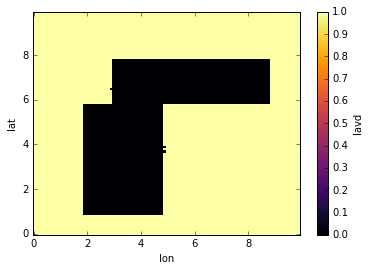

In [79]:
ds.lavd.plot(cmap='inferno')